Load training and testing datasets for the neural network model

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# File paths for the train and test data
file_path_train = "clean_traindata.csv"
file_path_test = "clean_testdata.csv"

# Load training and testing data
training_data = pd.read_csv(file_path_train)
testing_data = pd.read_csv(file_path_test)

# Separate the target column (Price) to ensure it remains the last column
price_column_train = training_data['SalePrice']
price_column_test = testing_data['SalePrice']

# Drop the target column from the datasets before encoding
training_data = training_data.drop(columns=['SalePrice'])
testing_data = testing_data.drop(columns=['SalePrice'])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the specified columns in the training dataset
encoded_columns_train = encoder.fit_transform(training_data[['encode_neighborhood', 'Encode_BldgType']])

# Transform the specified columns in the test dataset using the same encoder
encoded_columns_test = encoder.transform(testing_data[['encode_neighborhood', 'Encode_BldgType']])

# Convert the encoded arrays back to DataFrames with proper column names
encoded_columns_train_df = pd.DataFrame(encoded_columns_train, columns=encoder.get_feature_names_out(['encode_neighborhood', 'Encode_BldgType']))
encoded_columns_test_df = pd.DataFrame(encoded_columns_test, columns=encoder.get_feature_names_out(['encode_neighborhood', 'Encode_BldgType']))

# Reset indices to align with the original datasets
encoded_columns_train_df.index = training_data.index
encoded_columns_test_df.index = testing_data.index

# Drop the original categorical columns and add the new encoded columns
training_data = pd.concat([training_data.drop(columns=['encode_neighborhood', 'Encode_BldgType']), encoded_columns_train_df], axis=1)
testing_data = pd.concat([testing_data.drop(columns=['encode_neighborhood', 'Encode_BldgType']), encoded_columns_test_df], axis=1)

# Add the Price column back as the last column
training_data['Price'] = price_column_train
testing_data['Price'] = price_column_test
training_data = training_data.drop(columns=['Id'])
testing_data = testing_data.drop(columns=['Id'])

# Splitting features (x) and target (y)
x_train = training_data.iloc[:, :-1]
y_train = np.log(training_data.iloc[:, -1])

x_test = testing_data.iloc[:, :-1]
y_test = np.log(testing_data.iloc[:, -1])

#scale the training and testing data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Normalizing the target variable

y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train_normalized = (y_train - y_train_mean) / y_train_std
y_test_normalized = (y_test - y_train_mean) / y_train_std



# Split the training data into training and validation sets
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train_scaled, y_train_normalized, test_size=0.2, random_state=42
)

# Now use x_train_split and y_train_split for training,
# and x_val and y_val for validation.



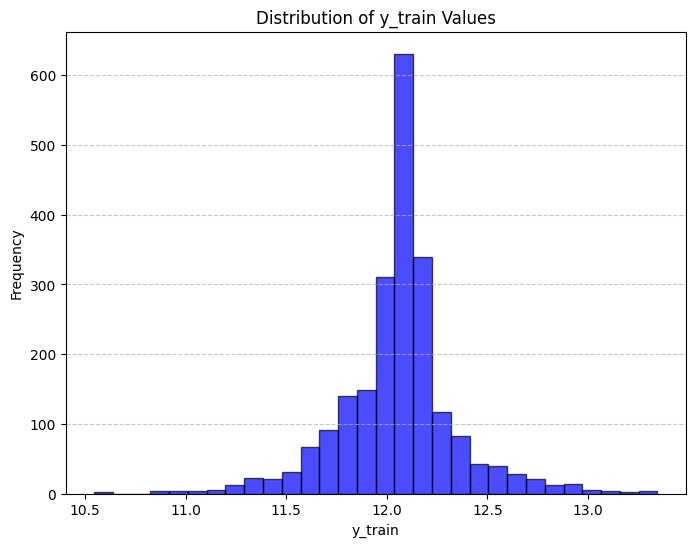

In [5]:
import matplotlib.pyplot as plt
# Plotting y_train without normalization
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of y_train Values")
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Function to build the model
def build_model(hidden_layers, nodes_per_layer, activation_function, output_activation):
    model = Sequential()
    for _ in range(hidden_layers):
        model.add(Dense(nodes_per_layer, activation=activation_function))
    model.add(Dense(1, activation=output_activation))  # Output layer
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mse'])
    return model

# Cross-validation function
def cross_validate_model(x_data, y_data, hidden_layers, nodes_per_layer, activation_function, batch_size, epochs, output_activation, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Define KFold object
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_data)):
        print(f"Starting fold {fold + 1}/{n_splits}")

        # Split the data into training and validation for this fold
        x_train, x_val = x_data[train_idx], x_data[val_idx]
        y_train, y_val = y_data[train_idx], y_data[val_idx]

        # Build and train the model
        model = build_model(hidden_layers, nodes_per_layer, activation_function, output_activation)
        history = model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            verbose=1
        )

        # Evaluate the model on the validation set
        val_loss, val_mae, val_mse = model.evaluate(x_val, y_val, verbose=0)
        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")

        # Save results for this fold
        fold_results.append((val_loss, val_mae, val_mse))

    # Compute the average performance across all folds
    avg_results = np.mean(fold_results, axis=0)
    print(f"\nCross-Validation Results - Average Loss: {avg_results[0]:.4f}, MAE: {avg_results[1]:.4f}, MSE: {avg_results[2]:.4f}")

    return fold_results, avg_results


In [8]:
def train_and_evaluate(hidden_layers, nodes_per_layer, activation_function, batch_size, epochs, output_activation):
    # Build the model with the specified parameters
    model = build_model(hidden_layers, nodes_per_layer, activation_function, output_activation)

    # Fit the model and store the training history
    # Use validation data (x_val, y_val) to monitor the model's performance
    history = model.fit(
        x_train_split, y_train_split,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=2
    )

    # Evaluate the model on the test data (x_test_scaled, y_test_normalized)
    test_evaluation = model.evaluate(x_val, y_val, verbose=1)

    test_loss = test_evaluation[0]
    test_metrics = test_evaluation[1:]

    return history, test_loss, test_metrics


Testing the model with sample parameters

In [9]:
# Define sample parameters
hidden_layers = 4
nodes_per_layer = 64
activation_function = 'relu'
batch_size = 32
epochs = 10
output_activation = None  # For regression tasks

# Call the train_and_evaluate function with the sample parameters
history, test_loss, test_metrics = train_and_evaluate(
    hidden_layers,
    nodes_per_layer,
    activation_function,
    batch_size,
    epochs,
    output_activation
)

# Print the results
print("Test Loss:", test_loss)
print("Test Metrics (MAE, MSE):", test_metrics)


Epoch 1/10
55/55 - 4s - 74ms/step - loss: 0.6687 - mae: 0.6072 - mse: 0.6687 - val_loss: 0.6082 - val_mae: 0.6069 - val_mse: 0.6082
Epoch 2/10
55/55 - 0s - 4ms/step - loss: 0.5233 - mae: 0.5605 - mse: 0.5233 - val_loss: 0.5913 - val_mae: 0.5980 - val_mse: 0.5913
Epoch 3/10
55/55 - 0s - 4ms/step - loss: 0.4895 - mae: 0.5432 - mse: 0.4895 - val_loss: 0.5966 - val_mae: 0.6086 - val_mse: 0.5966
Epoch 4/10
55/55 - 0s - 4ms/step - loss: 0.4707 - mae: 0.5290 - mse: 0.4707 - val_loss: 0.6296 - val_mae: 0.6169 - val_mse: 0.6296
Epoch 5/10
55/55 - 0s - 4ms/step - loss: 0.4613 - mae: 0.5223 - mse: 0.4613 - val_loss: 0.6237 - val_mae: 0.6199 - val_mse: 0.6237
Epoch 6/10
55/55 - 0s - 4ms/step - loss: 0.4461 - mae: 0.5137 - mse: 0.4461 - val_loss: 0.6127 - val_mae: 0.6090 - val_mse: 0.6127
Epoch 7/10
55/55 - 0s - 4ms/step - loss: 0.4427 - mae: 0.5110 - mse: 0.4427 - val_loss: 0.6586 - val_mae: 0.6267 - val_mse: 0.6586
Epoch 8/10
55/55 - 0s - 4ms/step - loss: 0.4279 - mae: 0.5042 - mse: 0.4279 - val_

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Define parameter ranges
hidden_layers_options = [4, 6]  # Number of hidden layers
nodes_per_layer_options = [32, 64, 128]  # Nodes per layer
activation_functions = ['relu', 'tanh']  # Activation functions
batch_sizes = [32, 64, 128]  # Batch sizes
epochs_options = [10, 20]  # Number of epochs
output_activation = None  # Output activation (regression)

# Initialize a list to store results
results = []

# Number of folds for cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through parameter combinations(grid search)
for hidden_layers in hidden_layers_options:
    for nodes_per_layer in nodes_per_layer_options:
        for activation_function in activation_functions:
            for batch_size in batch_sizes:
                for epochs in epochs_options:
                    print(f"Training model with: "
                          f"hidden_layers={hidden_layers}, "
                          f"nodes_per_layer={nodes_per_layer}, "
                          f"activation_function={activation_function}, "
                          f"batch_size={batch_size}, epochs={epochs}")

                    # Initialize variables to store fold results
                    fold_losses = []
                    fold_maes = []
                    fold_mses = []

                    # Cross-validation loop
                    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_scaled)):
                        x_train_fold, x_val_fold = x_train_scaled[train_idx], x_train_scaled[val_idx]
                        y_train_fold, y_val_fold = y_train_normalized.values[train_idx], y_train_normalized.values[val_idx]

                        # Build and train the model
                        model = build_model(hidden_layers, nodes_per_layer, activation_function, output_activation)
                        model.fit(
                            x_train_fold, y_train_fold,
                            validation_data=(x_val_fold, y_val_fold),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0
                        )

                        # Evaluate the model on the validation fold
                        val_loss, val_mae, val_mse = model.evaluate(x_val_fold, y_val_fold, verbose=0)
                        fold_losses.append(val_loss)
                        fold_maes.append(val_mae)
                        fold_mses.append(val_mse)

                    # Compute average results across folds
                    avg_loss = np.mean(fold_losses)
                    avg_mae = np.mean(fold_maes)
                    avg_mse = np.mean(fold_mses)

                    print(f"Avg Validation Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}, MSE: {avg_mse:.4f}")

                    # Append the results (parameters and performance) to the list
                    results.append([
                        hidden_layers,
                        nodes_per_layer,
                        activation_function,
                        batch_size,
                        epochs,
                        avg_loss,
                        avg_mae,
                        avg_mse
                    ])

# Convert the results to a NumPy array for easy analysis
results_array = np.array(results, dtype=object)

# Save results to a CSV file
np.savetxt("cross_validation_results.csv", results_array, delimiter=",", fmt='%s',
           header="hidden_layers,nodes_per_layer,activation_function,batch_size,epochs,avg_loss,avg_mae,avg_mse")

print("Cross-validation grid search complete. Results saved to 'cross_validation_results.csv'.")


Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=32, epochs=10
Avg Validation Loss: 0.5744, MAE: 0.5849, MSE: 0.5744
Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=32, epochs=20
Avg Validation Loss: 0.5920, MAE: 0.5858, MSE: 0.5920
Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=64, epochs=10
Avg Validation Loss: 0.5719, MAE: 0.5843, MSE: 0.5719
Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=64, epochs=20
Avg Validation Loss: 0.5895, MAE: 0.5845, MSE: 0.5895
Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=128, epochs=10
Avg Validation Loss: 0.5708, MAE: 0.5808, MSE: 0.5708
Training model with: hidden_layers=4, nodes_per_layer=32, activation_function=relu, batch_size=128, epochs=20
Avg Validation Loss: 0.5767, MAE: 0.5848, MSE: 0.5767
Training model with:

In [11]:
history, test_loss, test_metrics = train_and_evaluate(6,32,'tanh',64,20, output_activation=None)
print (test_metrics)

Epoch 1/20
28/28 - 6s - 204ms/step - loss: 0.7131 - mae: 0.6239 - mse: 0.7131 - val_loss: 0.6951 - val_mae: 0.6394 - val_mse: 0.6951
Epoch 2/20
28/28 - 0s - 6ms/step - loss: 0.5649 - mae: 0.5751 - mse: 0.5649 - val_loss: 0.6317 - val_mae: 0.6196 - val_mse: 0.6317
Epoch 3/20
28/28 - 0s - 5ms/step - loss: 0.5266 - mae: 0.5615 - mse: 0.5266 - val_loss: 0.6238 - val_mae: 0.6179 - val_mse: 0.6238
Epoch 4/20
28/28 - 0s - 5ms/step - loss: 0.5144 - mae: 0.5546 - mse: 0.5144 - val_loss: 0.6046 - val_mae: 0.6050 - val_mse: 0.6046
Epoch 5/20
28/28 - 0s - 5ms/step - loss: 0.5140 - mae: 0.5562 - mse: 0.5140 - val_loss: 0.6166 - val_mae: 0.6057 - val_mse: 0.6166
Epoch 6/20
28/28 - 0s - 5ms/step - loss: 0.5139 - mae: 0.5502 - mse: 0.5139 - val_loss: 0.5964 - val_mae: 0.5947 - val_mse: 0.5964
Epoch 7/20
28/28 - 0s - 10ms/step - loss: 0.4892 - mae: 0.5437 - mse: 0.4892 - val_loss: 0.6088 - val_mae: 0.6119 - val_mse: 0.6088
Epoch 8/20
28/28 - 0s - 6ms/step - loss: 0.4884 - mae: 0.5392 - mse: 0.4884 - va

In [12]:
#change back to dollar to see the error
file_path_train = "clean_traindata.csv"
file_path_test = "clean_testdata.csv"

# Load training and testing data
training_data_1 = pd.read_csv(file_path_train)
testing_data_1 = pd.read_csv(file_path_test)
log_y_mean = np.mean(np.log(training_data_1['SalePrice']))
log_y_std = np.std(np.log(training_data_1['SalePrice']))


# Example values (replace with actual values from your dataset)
val_mae_normalized = 0.3  # MAE in the normalized space

# Undo normalization
log_mae = val_mae_normalized * log_y_std + log_y_mean

# Undo log transformation
mae_dollars = np.exp(log_mae)

print(f"MAE in normalized space: {val_mae_normalized}")
print(f"MAE in dollars: ${mae_dollars:,.2f}")


MAE in normalized space: 0.3
MAE in dollars: $187,840.06


Try Random forest and modify the train and test date for training on Random forest


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# File paths for the train and test data
file_path_train = "clean_traindata.csv"
file_path_test = "clean_testdata.csv"

# Load training and testing data
training_data = pd.read_csv(file_path_train)
testing_data = pd.read_csv(file_path_test)

# Separate the target column (SalePrice)
price_column_train = training_data['SalePrice']
price_column_test = testing_data['SalePrice']

# Drop the target column from the datasets before encoding
training_data = training_data.drop(columns=['SalePrice'])
testing_data = testing_data.drop(columns=['SalePrice'])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the specified columns in the training dataset
encoded_columns_train = encoder.fit_transform(training_data[['encode_neighborhood', 'Encode_BldgType']])

# Transform the specified columns in the test dataset using the same encoder
encoded_columns_test = encoder.transform(testing_data[['encode_neighborhood', 'Encode_BldgType']])

# Convert the encoded arrays back to DataFrames with proper column names
encoded_columns_train_df = pd.DataFrame(encoded_columns_train, columns=encoder.get_feature_names_out(['encode_neighborhood', 'Encode_BldgType']))
encoded_columns_test_df = pd.DataFrame(encoded_columns_test, columns=encoder.get_feature_names_out(['encode_neighborhood', 'Encode_BldgType']))

# Reset indices to align with the original datasets
encoded_columns_train_df.index = training_data.index
encoded_columns_test_df.index = testing_data.index

# Drop the original categorical columns and add the new encoded columns
training_data = pd.concat([training_data.drop(columns=['encode_neighborhood', 'Encode_BldgType']), encoded_columns_train_df], axis=1)
testing_data = pd.concat([testing_data.drop(columns=['encode_neighborhood', 'Encode_BldgType']), encoded_columns_test_df], axis=1)

# Add the Price column back
training_data['Price'] = price_column_train
testing_data['Price'] = price_column_test

# Drop unnecessary columns (e.g., ID)
training_data = training_data.drop(columns=['Id'], errors='ignore')
testing_data = testing_data.drop(columns=['Id'], errors='ignore')

# Splitting features (X) and target (y)
X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1]

X_test = testing_data.iloc[:, :-1]
y_test = testing_data.iloc[:, -1]

# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, max_depth = 10,	min_samples_split = 2,	min_samples_leaf = 1)
rf_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: ${mae:.2f}")
print(f"Validation MSE: ${mse:.2f}")
print(f"Validation R2 Score: {r2:.2f}")



Validation MAE: $32602.56
Validation MSE: $2421540477.85
Validation R2 Score: 0.26


In [14]:
X_train

,OverallQual,OverallCond,YearRemodAdd,ExterCond,has_basement,TotalBsmtSF,has_garage,has_pool,ExterQual,TotalLivingArea,...,encode_neighborhood_21,encode_neighborhood_22,encode_neighborhood_23,encode_neighborhood_24,encode_neighborhood_25,Encode_BldgType_1,Encode_BldgType_2,Encode_BldgType_3,Encode_BldgType_4,Encode_BldgType_5
0,7,5,2007,3,1,1264.0,1,0,4,2696,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4,4,1955,3,1,1190.0,1,0,3,1540,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5,7,1995,3,1,728.0,1,0,3,1644,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,7,5,2005,3,1,848.0,1,0,4,1598,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,5,1958,4,1,1052.0,1,0,4,1920,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,7,5,2003,3,1,868.0,1,0,4,1146,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2196,7,5,2007,3,1,1266.0,1,0,4,1266,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2197,7,5,2003,3,1,1337.0,1,0,4,1337,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2198,6,7,1954,3,1,936.0,1,0,3,984,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


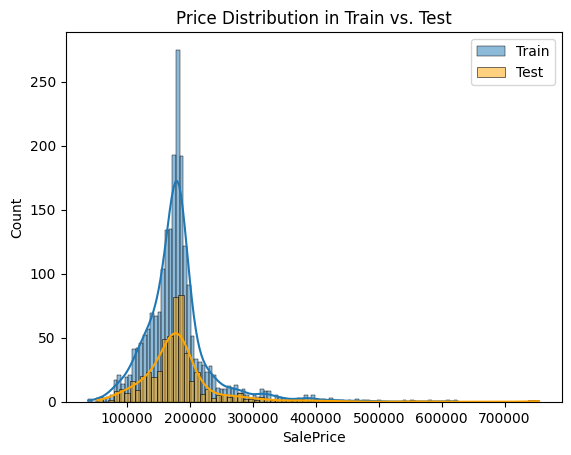

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
file_path_train = "clean_traindata.csv"
file_path_test = "clean_testdata.csv"

# Load training and testing data
training_data_1 = pd.read_csv(file_path_train)
testing_data_1 = pd.read_csv(file_path_test)
sns.histplot(training_data_1['SalePrice'], kde=True, label="Train")
sns.histplot(testing_data_1['SalePrice'], kde=True, color="orange", label="Test")
plt.legend()
plt.title("Price Distribution in Train vs. Test")
plt.show()


In [16]:
# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate on test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE: ${test_mae:.2f}")
print(f"Test MSE: ${test_mse:.2f}")
print(f"Test R2 Score: {test_r2:.2f}")


Test MAE: $28480.26
Test MSE: $1849108189.27
Test R2 Score: 0.55


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming x_train, y_train, x_test, y_test are already defined as in the provided preprocessing code

# Parameter grid for Random Forest
n_estimators_options = [100, 200, 300, 500]
max_depth_options = [None, 10, 20, 30]
min_samples_split_options = [2, 5]
min_samples_leaf_options = [1, 2]


# Initialize list to store results
results = []

# Loop through parameter combinations
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        for min_samples_split in min_samples_split_options:
            for min_samples_leaf in min_samples_leaf_options:
                print(f"Training Random Forest with: "
                      f"n_estimators={n_estimators}, "
                      f"max_depth={max_depth}, "
                      f"min_samples_split={min_samples_split}, "
                      f"min_samples_leaf={min_samples_leaf}")

                # Initialize and train Random Forest model
                rf_model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
                rf_model.fit(X_train, y_train)

                # Predict on test data
                y_test_pred = rf_model.predict(X_test)

                # Evaluate the model
                mae = mean_absolute_error(y_test, y_test_pred)
                mse = mean_squared_error(y_test, y_test_pred)
                rmse = np.sqrt(mse)

                # Append results (parameters and performance) to the list
                results.append([
                    n_estimators, max_depth, min_samples_split, min_samples_leaf, mae, mse, rmse
                ])

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results, columns=[
    "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "mae", "mse", "rmse"
])


Training Random Forest with: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1
Training Random Forest with: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2
Training Random Forest with: n_estimators=100, max_depth=None, min_samples_split=5, min_samples_leaf=1
Training Random Forest with: n_estimators=100, max_depth=None, min_samples_split=5, min_samples_leaf=2
Training Random Forest with: n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1
Training Random Forest with: n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=2
Training Random Forest with: n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1
Training Random Forest with: n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2
Training Random Forest with: n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1
Training Random Forest with: n_estimators=100, max_depth=20, min_samples_split=2, m

In [18]:
import pandas as pd

# Load the results from the CSV file generated in the previous s

# Find the best model based on the lowest RMSE (Root Mean Squared Error)
best_model = results_df.loc[results_df['rmse'].idxmin()]

# Display the best model's parameters and performance
best_model_df = pd.DataFrame(best_model).transpose()

# Save the best model details to a new CSV file
best_model_df.to_csv("best_random_forest_model.csv", index=False)

# Display the best model's details
print("Best Random Forest model details saved to 'best_random_forest_model.csv'.")
best_model_df


Best Random Forest model details saved to 'best_random_forest_model.csv'.


,n_estimators,max_depth,min_samples_split,min_samples_leaf,mae,mse,rmse
20,200.0,10.0,2.0,1.0,28501.004784,1.890877e+09,43484.210157


In [19]:
best_model = RandomForestRegressor(n_estimators=200, max_depth = 10,	min_samples_split = 2,	min_samples_leaf = 1)
best_model.fit(X_train, y_train)




RandomForestRegressor(max_depth=10, n_estimators=200)

Try ensemble method on combining random forest with neural network by averaging their output. Due to limited computation power, we used hyperparameter from previous grid search.

In [27]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

hidden_layers = 6
nodes_per_layer = 32
activation_function = 'relu'
batch_size = 64
epochs = 2000

mlp_model = MLPRegressor(
    hidden_layer_sizes=(nodes_per_layer,) * hidden_layers,
    activation=activation_function,
    solver='adam',
    batch_size=batch_size,
    max_iter=epochs,
    random_state=42
)


# Train the Random Forest
rf_model.fit(X_train_split, y_train_split)

# Train the Neural Network
mlp_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_mlp = mlp_model.predict(X_val)

# Combine predictions by averaging
y_val_pred_ensemble = (y_val_pred_rf + y_val_pred_mlp) / 2.0

# Evaluate the ensemble predictions on the validation set
mae = mean_absolute_error(y_val, y_val_pred_ensemble)
mse = mean_squared_error(y_val, y_val_pred_ensemble)
r2 = r2_score(y_val, y_val_pred_ensemble)

print("---- Validation Set Evaluation ----")
print(f"Ensemble Validation MAE: ${mae:.2f}")
print(f"Ensemble Validation MSE: ${mse:.2f}")
print(f"Ensemble Validation R2 Score: {r2:.2f}")

# Predict on the test set
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_mlp = mlp_model.predict(X_test)

y_test_pred_ensemble = (y_test_pred_rf + y_test_pred_mlp) / 2.0

# Evaluate on the test set
test_mae = mean_absolute_error(y_test, y_test_pred_ensemble)
test_mse = mean_squared_error(y_test, y_test_pred_ensemble)
test_r2 = r2_score(y_test, y_test_pred_ensemble)

print("---- Test Set Evaluation ----")
print(f"Ensemble Test MAE: ${test_mae:.2f}")
print(f"Ensemble Test MSE: ${test_mse:.2f}")
print(f"Ensemble Test R2 Score: {test_r2:.2f}")

---- Validation Set Evaluation ----
Ensemble Validation MAE: $32051.05
Ensemble Validation MSE: $2074293668.75
Ensemble Validation R2 Score: 0.37
---- Test Set Evaluation ----
Ensemble Test MAE: $28608.24
Ensemble Test MSE: $1923679109.23
Ensemble Test R2 Score: 0.53


In [21]:
#Store the model and encoder
import joblib
joblib.dump(encoder, 'encoder.pkl')
print(type(encoder))

<class 'sklearn.preprocessing._encoders.OneHotEncoder'>


In [23]:
loaded_model = joblib.load('encoder.pkl')
print(type(loaded_model))

<class 'sklearn.preprocessing._encoders.OneHotEncoder'>


## Ultimately, the standalone Neural Network, optimized through hyperparameter tuning, proved to be the most accurate model. It achieved a best-in-class result of 187,840.06, significantly outperforming both the Random Forest model and the combined Ensemble method.